# Problem 2: An SNN tackling a real-world classification problem

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

np.random.seed(101)

def sample_spherical(npoints, ndim): #sample a vector of dimension "ndim" from the unit sphere randomly
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec[:,0]

def normalize_images(data): #normalize pixel values to [-1, 1] 
    for i in range(data.shape[0]):
        img = data[i]
        data[i] = 2*(img - min(img))/(max(img) - min(img)) - 1
    return data

def PSC_filter(Tsim, dt, tau):
    t = np.linspace(0,Tsim,int(np.round(Tsim/dt)))
    h = np.exp(-(t-Tsim/2)/tau)
    h[0:len(h)//2] = 0
    h = (1/dt)*h/np.sum(h)
    return h

In [63]:
"""
Simulating LIF Neuron
"""

def simulate_neuron(Tsim, dt, t_rc, t_ref, vrest, vth, J):
    N = int(np.round(Tsim/dt))
    Vprev = 0
    Jprev = 0
    spike_train = np.zeros(N)
    Vhist = np.zeros(N)
    mutex = 0  
    
    for i in range(N):
        if mutex == 0:
            V = (J[i] + Jprev - (1-2*t_rc/dt)*Vprev)/(1+2*t_rc/dt) #bilinear transform
            if V < vrest:
                V = vrest
            elif V > vth:
                spike_train[i] = 1
                V = vrest
                mutex = np.round(t_ref/dt)
            Vhist[i] = V 
            Jprev = J[i]
            Vprev = V
        else:
            mutex -= 1
    
    return Vhist, spike_train


# # # setup parameters and state variables
# Tsim = 0.50                        # total time to simulate (msec)
# dt = 0.001                    # simulation time step (msec)
# time = np.arange(0, Tsm+dt, dt) # time array
# t_rest = 0                    # initial refractory time

# # # LIF properties
# V = np.zeros(len(time)) # potential (V) trace over time
# # Rm = 1                   # resistance (kOhm)
# # Cm = 10                  # capacitance (uF)
# # tau_m = Rm*Cm            # time constant (msec)
# # tau_ref = 4              # refractory period (msec)
# # Vth = 1                  # spike threshold (V)
# # V_spike = 10.0           # spike delta (V)

# # I = 2.0 * np.ones(len(time))        # input current (A)
# # noise = []                          # noise term


# def simulate_neuron(Tsim, dt, t_rc, t_ref, v_rest, v_th, J):
#     for i, t in enumerate(time):
#         if t > t_rest:
#             randomTerm = np.random.normal(0,1)
#             noise.append(randomTerm)
#             Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm + randomTerm) / tau_m * dt
#             if Vm[i] >= Vth:
#                 Vm[i] += V_spike
#                 t_rest = t + tau_ref


## 2.1.1 Dataset & 2.1.2 Training Methodology

Split up the digits dataset and one hot encode the labels

In [132]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


digits = load_digits()
org_x, org_y = normalize_images(digits.data), digits.target

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(org_y.reshape(-1,1))

#GLOBALS
x, y, x_train, y_train, x_val, y_val, x_test, y_test 
one_hot_train, one_hot_val, one_hot_test

def get_digits(arr=[0,1,2,3,4,5,6,7,8,9]):
    digit_set = set(arr)
    new_x, new_y = [], []
    for i in range(len(org_x)):
        if org_y[i] in digit_set:
            new_x.append(org_x[i])
            new_y.append(org_y[i])
    
    global one_hot_train, one_hot_val, one_hot_test
    global x, y, x_train, y_train, x_val, y_val, x_test, y_test
            
    x_train,x_test, y_train, y_test = train_test_split(new_x, new_y, train_size=0.70, random_state=101, stratify=new_y)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, random_state=101,stratify=y_test)
    
    
    
    x, y, x_train, y_train, x_val, y_val, x_test, y_test = np.array(new_x), np.array(new_y), np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)
    
    one_hot_train = enc.transform(y_train.reshape(-1,1)).toarray()
    one_hot_val = enc.transform(y_val.reshape(-1,1)).toarray()
    one_hot_test = enc.transform(y_test.reshape(-1,1)).toarray()
    
    

So the split ratio is: 70/15/15 (training/validating/testing)

## 2.2 Exercises

In [133]:
from collections import Counter
Counter(org_y)

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

### 2.2.1

- (a)  64 input neurons because we want to have a neuron for each pixel and the image is 8x8 white & black image
- (b)  each digit class has rougly ~180 digits so if the model randomly picks a number it has a 10% chance of being correct
- (c)  3 output neurons for each of the 3 digits (1,2,5) and consequently you would need 10 output neurons for digits (0 - 9)
- (d)  I normalize each of the pixels to be value between -1 and 1 essentially we are using the magnitude of the pixel value. Then use that value 

# Digit Classification

In [168]:
input_size = 64 # 8 x 8 images
hidden_size = 25 # hidden layer

F_max_l = 100 #100
F_max_h = 200
in_l = -1.0
in_h = 1.0
t_ref = 0.002 #2ms
t_rc = 0.02 #20ms


#### Training

$J_M(x) = \alpha x + J^{bias}$
- $J_M$ is all past current input since *x*
- $\alpha$ is both the gain and a unit conversion factor
- $J^{bias}$ accounts for the steady background input to thecell

$a(x) = \frac{1}{\tau^{ref} - \tau^{RC}ln(1-\frac{J_{th}}{J_M(x)})}$
- $a(x)$ is the firing rate at time x
- $\tau^{ref}$ refractory period time constant
- $\tau^{RC} $



In [169]:
"""
Training 
"""
alpha_vec = np.zeros(hidden_size)
J_bias_vec = np.zeros(hidden_size)
e_vec = np.zeros((hidden_size, input_size))
d_reg

def train():
    num_input = len(x_train)

    A_train = np.zeros((num_input, hidden_size))
    
    for i in range(hidden_size):
        # maximum rate uniformly distributed between 100 and 200 HZ
        amax = np.random.uniform(F_max_l, F_max_h, 1) #F_max_l = 100 F_max_h = 200
        # x-intercept
        xi = np.random.uniform(-0.05, in_h, 1) #in_h = 1

        alpha = (1/(1-np.exp((t_ref - 1/amax)/t_rc)) - 1)/(1-xi)
        J_bias = 1 - xi * alpha
        e = sample_spherical(1, input_size)

        alpha_vec[i] = alpha
        J_bias_vec[i] = J_bias
        e_vec[i] = e

        a_x = np.zeros(num_input)
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_train[j])) + J_bias
            if J_M > 1:
                a_x[j] = 1/(t_ref - t_rc*np.log(1- 1/J_M))
            else:
                a_x[j] = 0

        A_train[:,i] = a_x




    mu, sigma = 0, 0.01*np.max(A_train) # mean and standard deviation
    s = np.random.normal(mu, sigma, A_train.shape)
    A_noisy = np.add(A_train, s) 
    
    global d_reg
    d_reg = np.linalg.lstsq(
        A_train.T @ A_train + 0.5 * num_input * np.square(sigma) * np.eye(hidden_size), A_train.T @ one_hot_train,rcond=None
    )[0].T

    x_hat = np.dot(A_noisy, d_reg.T)
    MSE = np.mean(np.power(one_hot_train-x_hat, 2))

#### Validation


In [170]:
    """
    Validation
    """
    def validate():
        num_input = len(x_val)

        Tsim = 0.1
        dt = 0.001
        v_rest = 0
        v_th = 1
        Tlen = int(np.round(Tsim/dt))
        A_val = np.zeros((num_input, Tlen, hidden_size))
    #     S_val = np.zeros((num_input, Tlen, hidden_size))
        h = PSC_filter(Tsim, dt, 0.05)
        t = np.linspace(0, Tsim, Tlen)

        for i in range(hidden_size):
            alpha = alpha_vec[i]
            J_bias = J_bias_vec[i]
            e = e_vec[i]
            a_x = np.zeros((num_input, Tlen))
            s_x = np.zeros((num_input, Tlen))

            for j in range(num_input):
                J_M = np.multiply(alpha, np.inner(e, x_val[j])) + J_bias

                Jin = np.concatenate((J_bias*np.ones(Tlen//4), J_M*np.ones(3*Tlen//4))) #present input to network at Tsim//2

                Vhist, spike_train = simulate_neuron(Tsim, dt, t_rc, t_ref, v_rest, v_th, Jin)
                a_x[j] = np.convolve(spike_train, h, 'same')
    #             spike_train[spike_train == 0] = -1
    #             s_x[j] = np.multiply(spike_train, t)


            A_val[:,:,i] = a_x
    #         S_val[:,:,i] = s_x



        error_history = np.zeros(Tlen)
        for t_i in range(Tlen):
            x_hat_val = np.dot(A_val[:,t_i,:], d_reg.T) #decode activity of the population

            cnt = 0
            for i in range(num_input): #count error rate of model    
                if np.argmax(x_hat_val[i]) != np.argmax(one_hot_val[i]):
                    cnt += 1

            error_rate = 100 - 100*cnt/num_input #compute error rate of model
            error_history[t_i] = error_rate

        """
        Accuracy evolution over time
        """ 
        plt.figure(figsize=(20,10))
        plt.plot(t, error_history, '.-')
        plt.title('Accuracy of model in function of time')
        plt.xlabel('Time [s]')
        plt.ylabel('Accuracy on test set [%]')
        plt.grid('on')
        plt.show()

#### Testing

In [171]:
"""
Testing
"""
def test():
    num_input = len(x_test)

    A_test = np.zeros((num_input, hidden_size))
    for i in range(hidden_size):
        alpha = alpha_vec[i]
        J_bias = J_bias_vec[i]
        e = e_vec[i]
        a_x = np.zeros(num_input)
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_test[j])) + J_bias

            if J_M > 1:
                a_x[j] = 1/(t_ref - t_rc*np.log(1- 1/J_M))
            else:
                a_x[j] = 0


        A_test[:,i] = a_x



    mu, sigma = 0, 0.01*np.max(A_test) # mean and standard deviation
    s = np.random.normal(mu, sigma, A_test.shape)
    A_noisy = np.add(A_test, s) 

    d_reg = np.linalg.lstsq(
        A_test.T @ A_test + 0.5 * num_input * np.square(sigma) * np.eye(hidden_size), A_test.T @ one_hot_test,rcond=None
    )[0].T

    x_hat = np.dot(A_noisy, d_reg.T)
    MSE = np.mean(np.power(one_hot_test-x_hat, 2))
    print("Testing MSE:", MSE)

In [172]:
def run(arr=None):
    if not arr:
        get_digits()
    else:
        get_digits(arr)
    train()
    validate()
    test()

### 2.2.2

**Training to Classify Digits: 1,8**

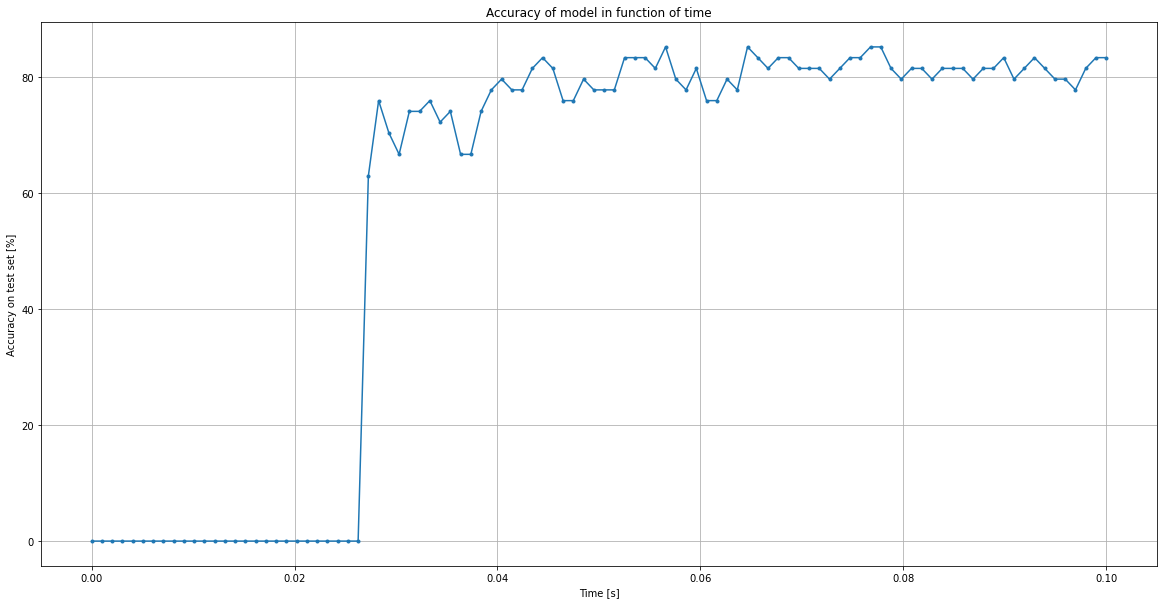

Testing MSE: 0.012290187116712228


In [173]:
run([1,8])

**Training to Classify Digits: 3,8**

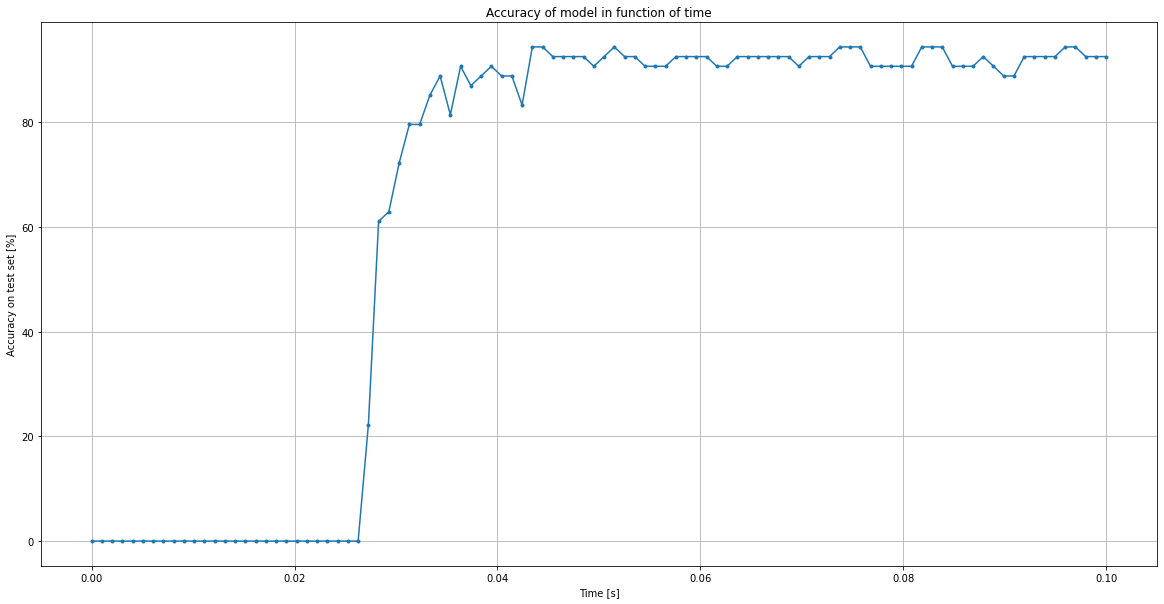

Testing MSE: 0.014515754092851236


In [174]:
run([3,8])

The error rate is higher on the 3,8 model compared to the 1,8 model this is likely due to the similarity in how 3 and 8 is written so it it will harder for the model to discern this difference. 1 and 8 are more distinct in terms of how they are written so it is easier to distinguish the two.

**Training to Classify Digits: 0-9**

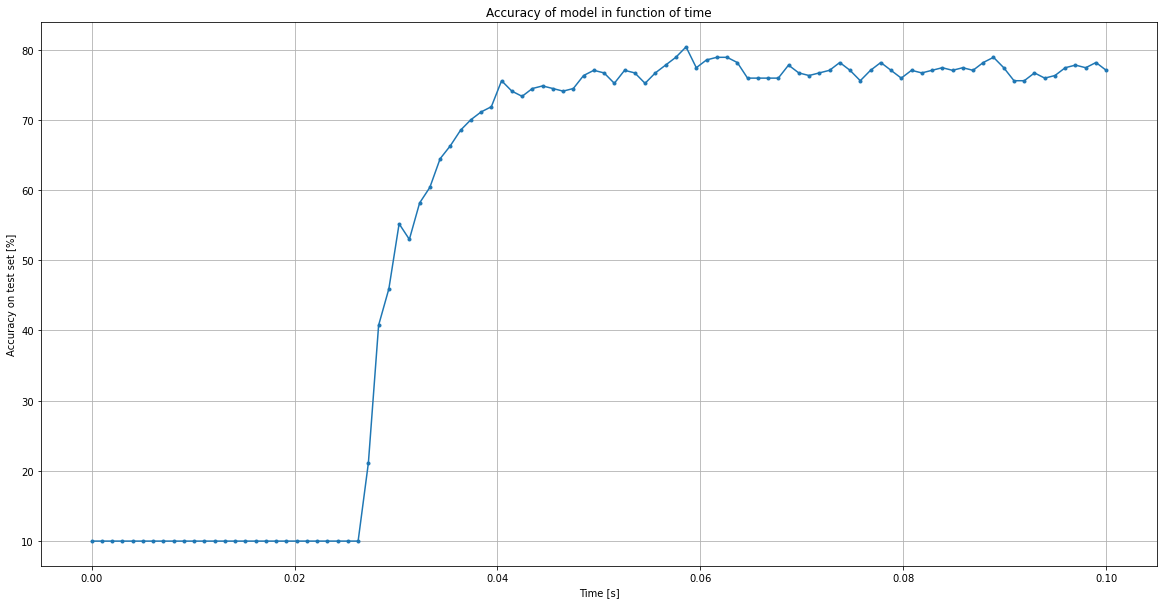

Testing MSE: 0.050189355244717446


In [175]:
run()

Our model is better than 10% accuracy which is what you will expect to get if you digits were simply chosen at random.

References

-[1] Eliasmith, Chris, and Charles H. Anderson. Neural Engineering: Computation, Representation, and Dynamics in Neurobiological Systems. Mitt Press, 2003. 
-[2] Ali Safa. (2020, July 19). Digit Classification Using a One-Hidden-Layer Spiking Neural Network (Version V1.3). Zenodo. http://doi.org/10.5281/zenodo.3951585